# Usage

In [1]:
from hydrodata import Dataloader

Hydrodata module downloads daily climate data for a USGS station based its ID or coordinates (longitude and latitude). It requires at least three parameters: start date, end date and USGS station ID or coordinates. The daily climate data are downloaded from the [Daymet](https://daymet.ornl.gov/) and [NWIS](https://nwis.waterdata.usgs.gov/nwis) datasets.

## Climate Data

For example, let's consider the following USGS station:

In [2]:
start, end = '2000-01-01', '2015-12-31'
station_id = '01467087'
gis_dir = '../examples/gis_data'
data_dir = '../examples/data'

Now, we can define an instance based on the station ID as follows:

In [3]:
frankford = Dataloader(start,
                       end,
                       station_id=station_id,
                       gis_dir=gis_dir,
                       data_dir=data_dir)

The gauge station is located in the following watershed:
Frankford Creek at Castor Ave, Philadelphia, PA


Upon instantiation, the station's information is found from NHDPlus V2 dataset. NHDPlus is automatically downloaded and unzipped. The climate data can be downloaded using `get_climate` function. The data is downloaded and saved as an HDF5 file. If the file exists, it is read from the disk.

In [4]:
frankford.get_climate()

Computing potential evapotranspiration (PET) using FAO method
climate data was downloaded successfuly andsaved to ../examples/data/4489096/20000101_20151231.h5


The data is returned as a `pandas` dataframe.

In [5]:
frankford.climate.head()

prcp (mm/day)  tmin (C)  tmax (C)  tmean (C)  pet (mm)  qobs (cms)
2000-01-01            0.0      -2.5       8.5        3.0      0.95    0.453070
2000-01-02            0.0       1.5      16.5        9.0      1.55    0.453070
2000-01-03            0.0       8.5      17.5       13.0      1.23    0.453070
2000-01-04           18.0       9.0      19.0       14.0      1.39    4.955448
2000-01-05            0.0       0.0      13.0        6.5      1.32    1.387525

Hydrodata has function that can separate snow and rain from the precipitation.

In [6]:
df = frankford.climate.copy()
df["pr (mm/day)"], df["ps (mm/day)"] = frankford.separate_snow(
    df["prcp (mm/day)"].values,
    df["tmean (C)"].values,
    tcr=0)
df.head()

prcp (mm/day)  tmin (C)  tmax (C)  tmean (C)  pet (mm)  \
2000-01-01            0.0      -2.5       8.5        3.0      0.95   
2000-01-02            0.0       1.5      16.5        9.0      1.55   
2000-01-03            0.0       8.5      17.5       13.0      1.23   
2000-01-04           18.0       9.0      19.0       14.0      1.39   
2000-01-05            0.0       0.0      13.0        6.5      1.32   

            qobs (cms)  pr (mm/day)  ps (mm/day)  
2000-01-01    0.453070          0.0          0.0  
2000-01-02    0.453070          0.0          0.0  
2000-01-03    0.453070          0.0          0.0  
2000-01-04    4.955448         18.0          0.0  
2000-01-05    1.387525          0.0          0.0

Moreover, longitude and latitude coordinate can also be used for downloading the data. The coordinate doesn't have to be exact since the closest station to the specified coordinates is found automatically. For example, let's find the climate data for a station close to longitude -76.43 and latitude of 41.08.

In [7]:
fishing = Dataloader(start,
                     end,
                     coords=(-76.43, 41.08),
                     gis_dir=gis_dir,
                     data_dir=data_dir)
fishing.get_climate()

The gage station is located in the following watershed:
Fishing Creek near Bloomsburg, PA
Computing potential evapotranspiration (PET) using FAO method
climate data was downloaded successfuly andsaved to ../examples/data/2603023/20000101_20151231.h5


## Land Use, Land Cover Data

Also, if geometry of a watershed as a `shapefile` is availble, the `get_lulc` function downloads land use land cover (LULC) data from the National Land Cover Database (NLCD) 2016 dataset. The data will be saved as a `geotiff` file and will be read from the disk if it's downloaded previousely.

In order to download the shapefile the watershed upstream of the USGS stations an R script, `nhdplus.R`, is provided in [hydrodata](https://github.com/cheginit/hydrodata) Github repository. First, open up a new terminal, then load the Anaconda framework and create an R enviroment as follows:
```bash
conda create -n nhdplus -c conda-forge r-rgdal r-sf r-curl r-httr r-prettymapr r-rosm r-optparse r-geojsonio && \
conda activate nhdplus && \
Rscript -e \
"options(repos = 'https://cran.revolutionanalytics.com'); \
install.packages('nhdplusTools');"
```
Next, run the script and pass the station ID (or the station coordinates) to the script;
```bash
./nhdplus.R -i 01467087
```

It automatically downloads the watershed geometry as a `shapefile` and plots it including its river network (main and tributaries) and save the plot as a `png` file. The `shapefile` is saved in the directory that is passed to the script (default is `gis_data`) under a directory named the (starting) ComID (Common identifier of an NHDFlowline feature) of the watershed. In this example the path is `gis_dir/4489096/geometry.shp`. Running `./nhdplus.R -h` shows more information about the script options.

Now the `get_lulc` function can be used to download the LULC data. This function has an optional argument for providing the path to the watershed geometry. The default is the same as the R script which in this example is `gis_dir/4489096/geometry.shp`.

In [8]:
frankford.get_lulc()

Downloadin impervious data from NLCD 2016 database
impervious data was downloaded successfuly and saved to ../examples/data/4489096/impervious.geotiff
Downloadin cover data from NLCD 2016 database
cover data was downloaded successfuly and saved to ../examples/data/4489096/cover.geotiff
Downloadin canopy data from NLCD 2016 database
canopy data was downloaded successfuly and saved to ../examples/data/4489096/canopy.geotiff


In [9]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

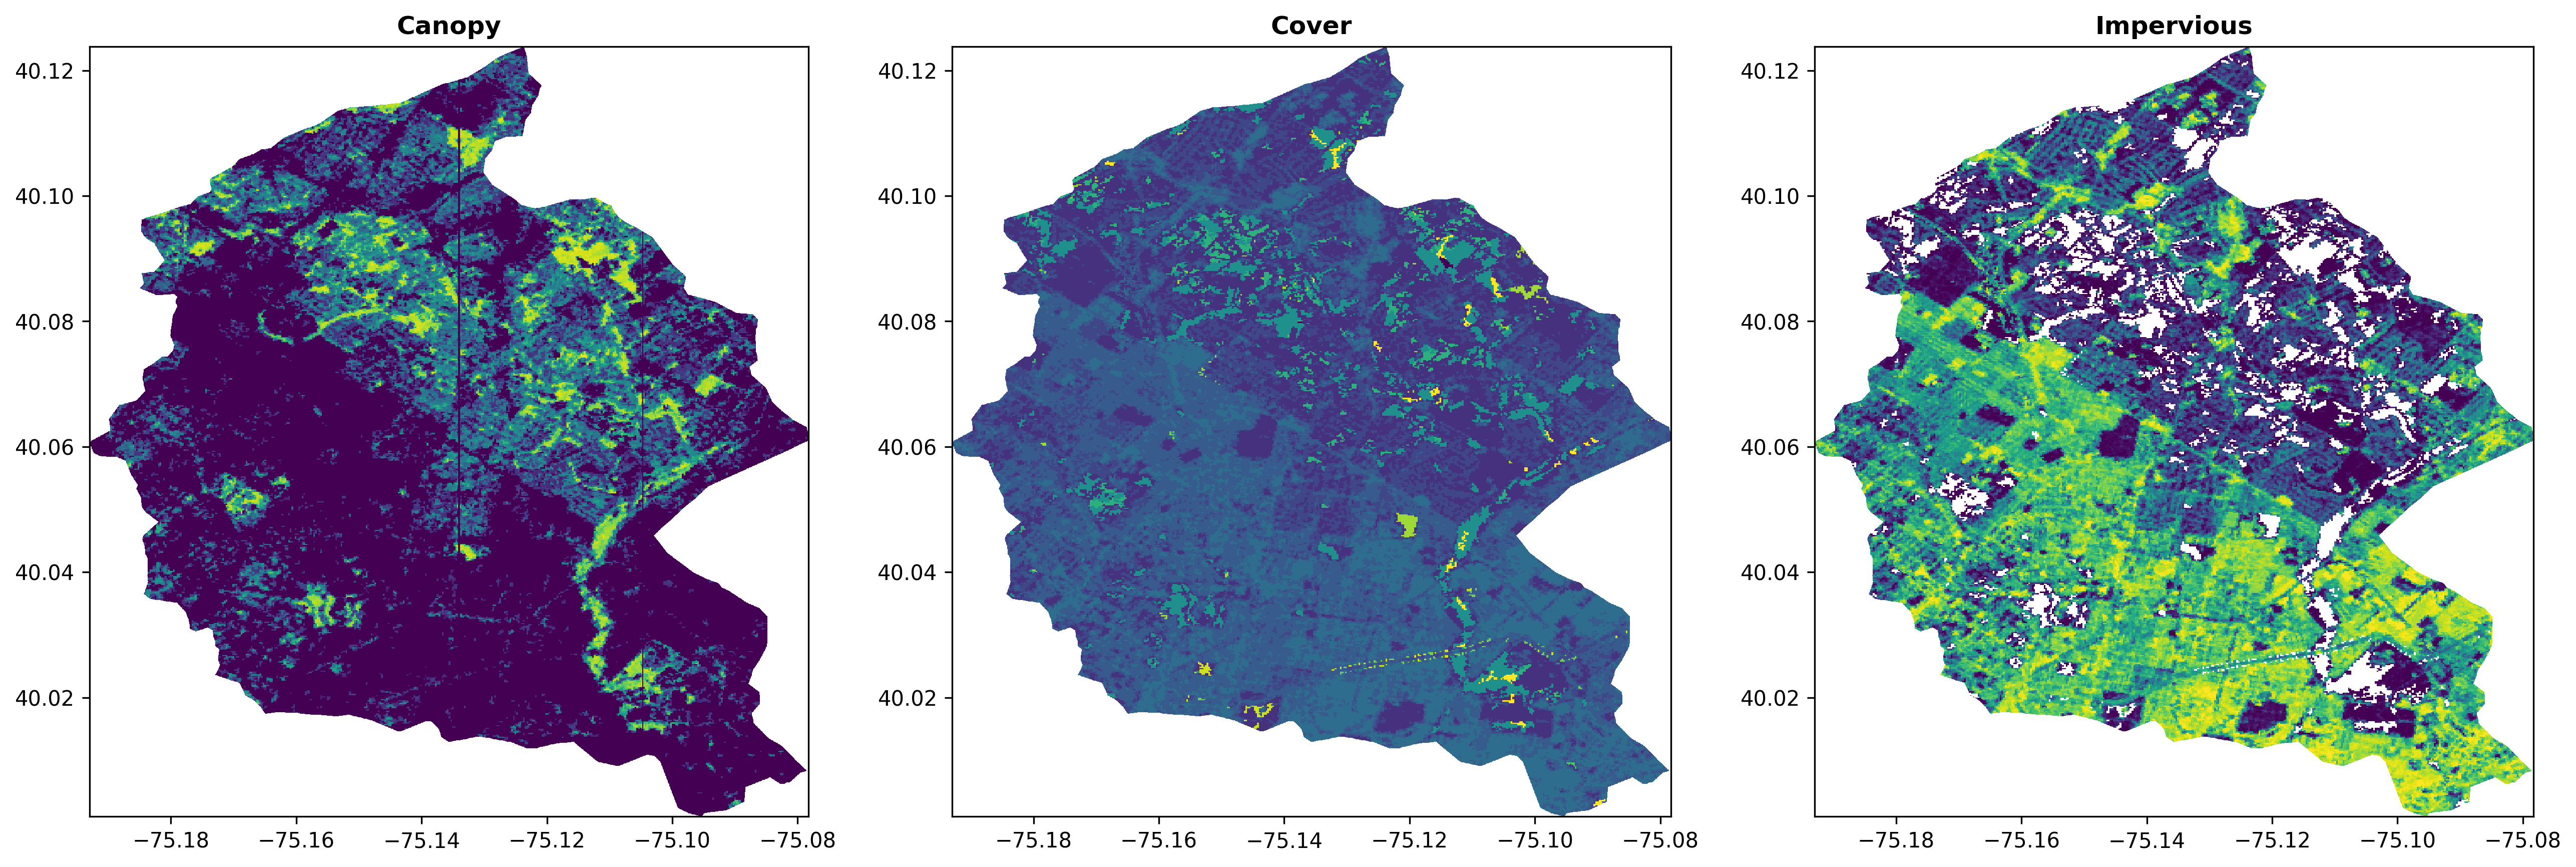

In [10]:
canopy = rasterio.open(frankford.data_dir.joinpath('canopy.geotiff'))
cover = rasterio.open(frankford.data_dir.joinpath('cover.geotiff'))
impervious = rasterio.open(frankford.data_dir.joinpath('impervious.geotiff'))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), dpi=300)
show(canopy, ax=ax1, title='Canopy')
show(cover, ax=ax2, title='Cover')
show(impervious, ax=ax3, title='Impervious');

## Plotting

The hydrologic signatures can be plotted easily using the `plot` and `plot_discharge` functions. These functions convert the streamflow data from cubic meter per second to millimeter per day based on the watershed area which should be provided in km$^2$. The function are written with three use cases in mind that are demonstrated below.

### Observed discharge for a station

In this case, the `plot` function can simply be called for any Hydrodata instance with just one optional argument for saving the plot as a `png` image.

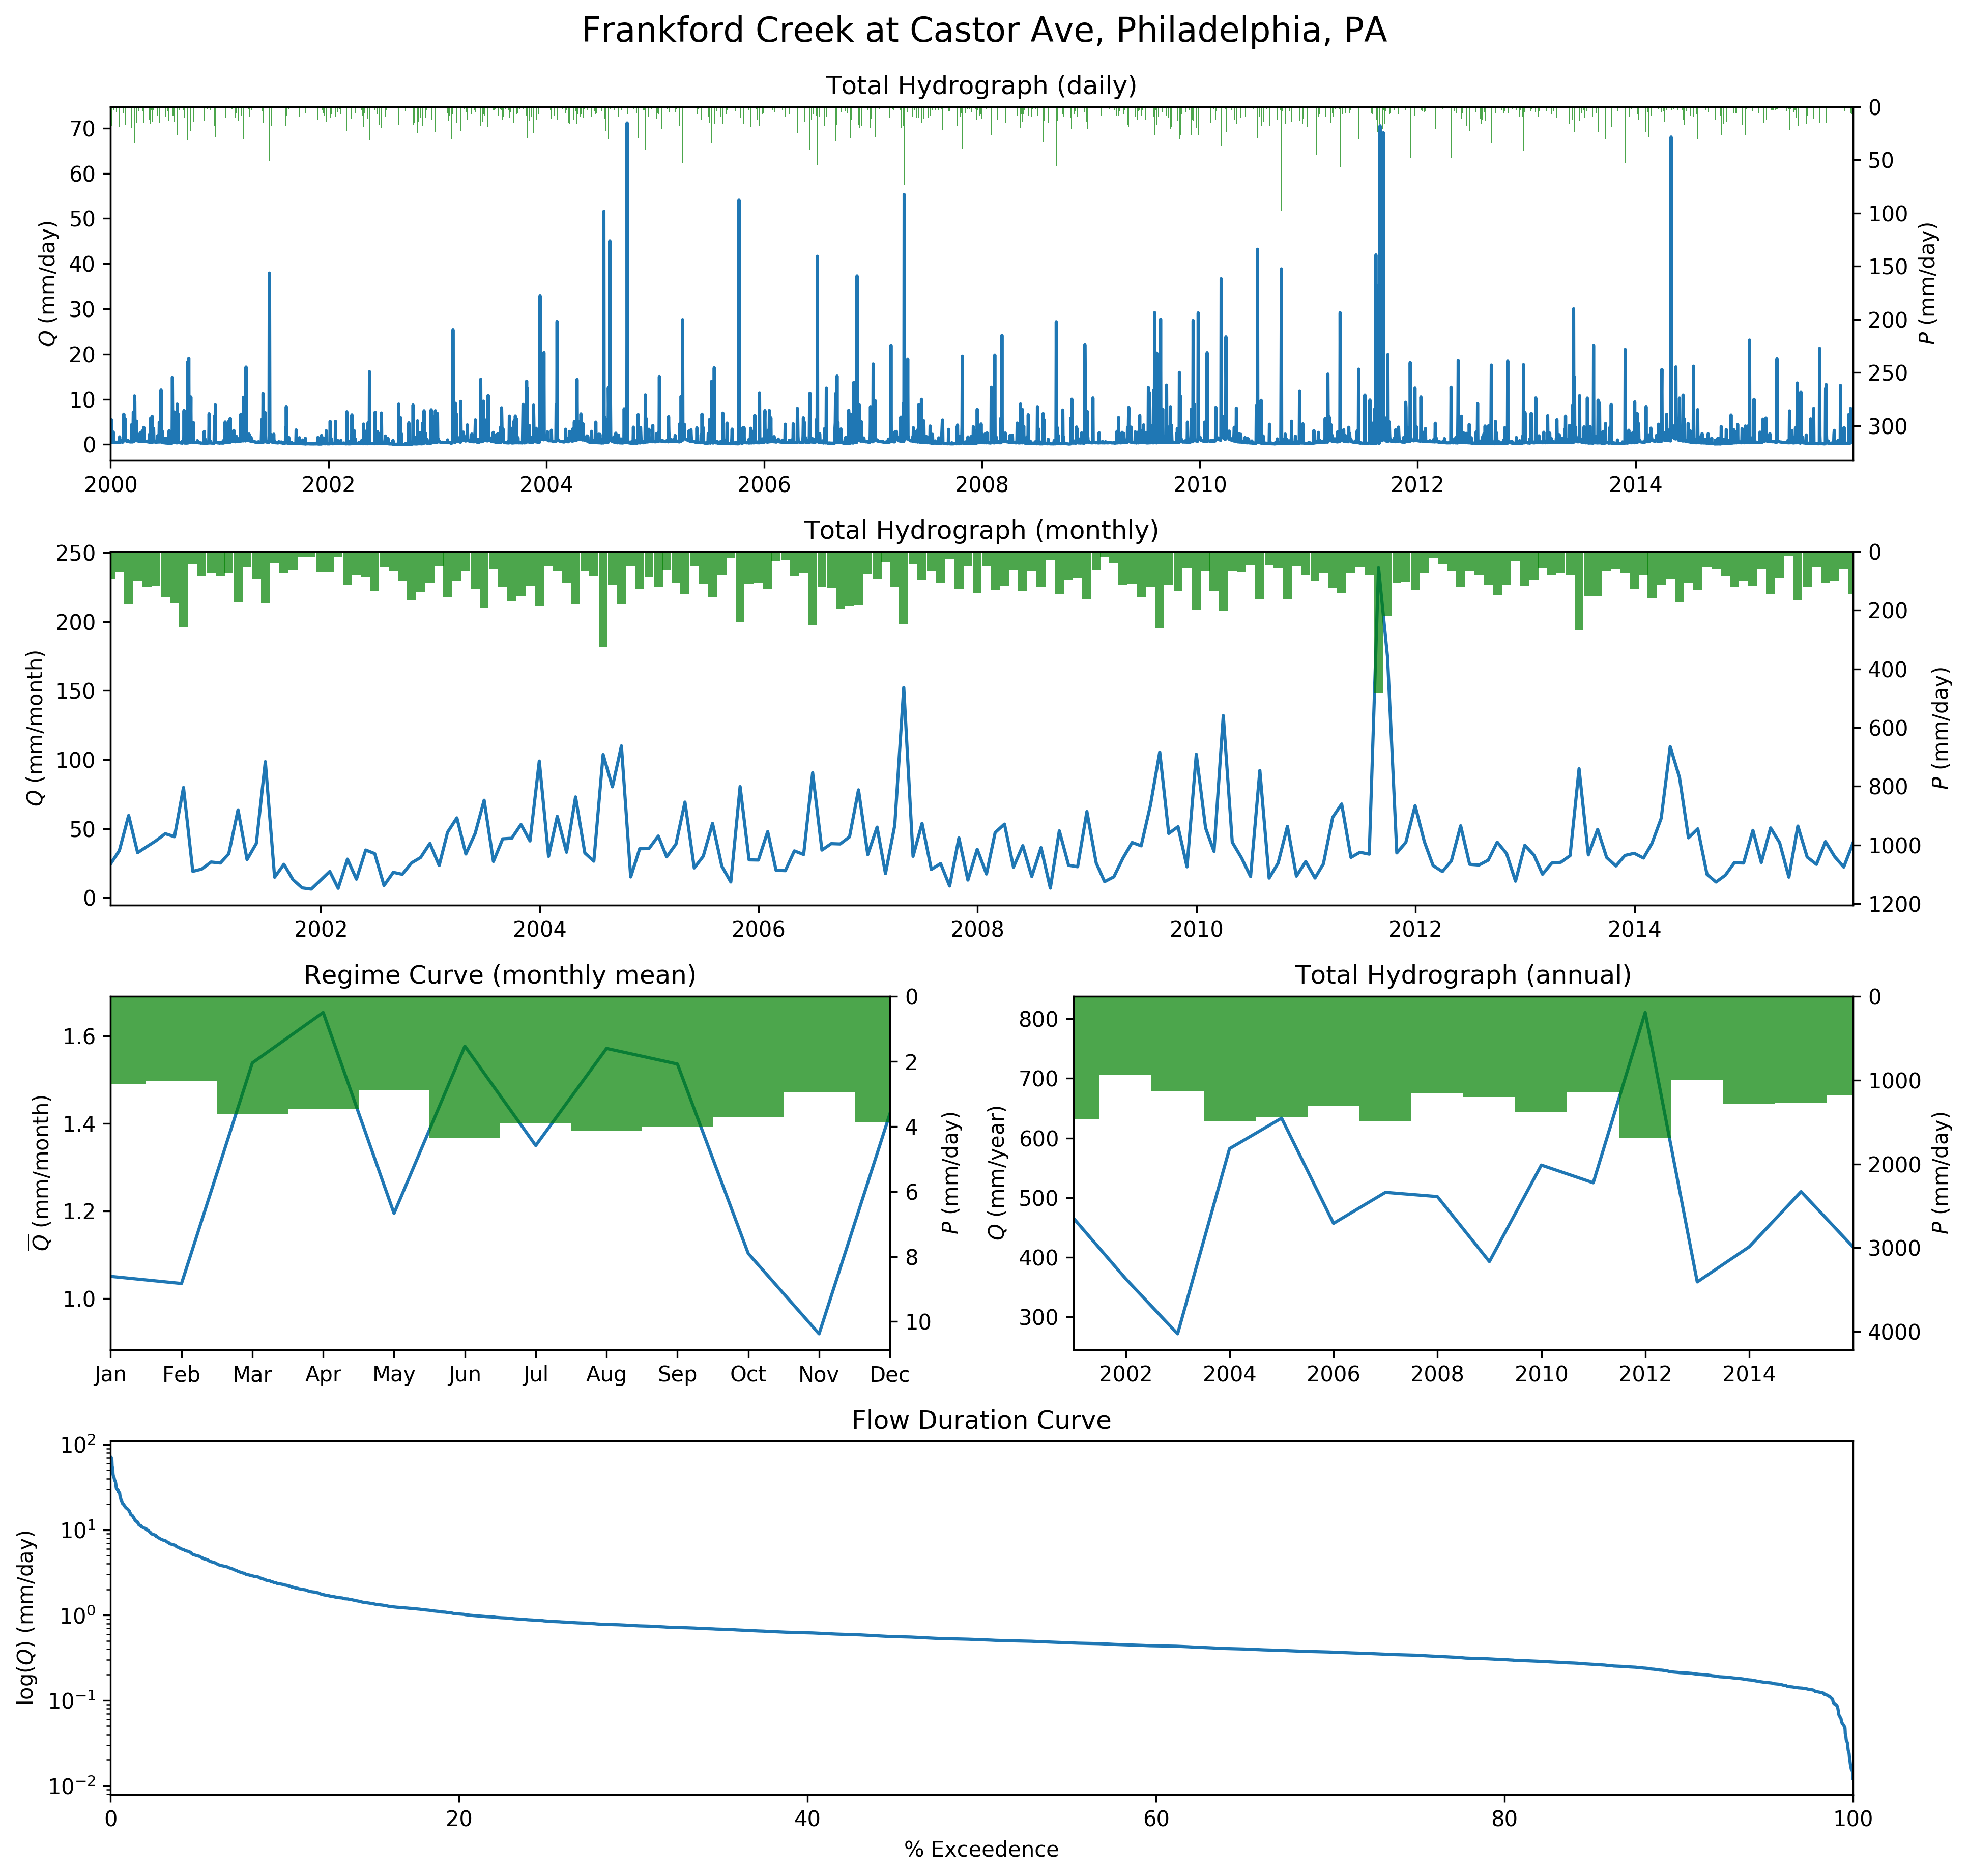

In [11]:
frankford.plot(output=f'Observed_{frankford.station_id}.png')

### Observed and simulated discharges for a station

In this case, the observed and simulation data are to be compared. For example, let's use [RRMPG](https://rrmpg.readthedocs.io/en/latest/) package to model the watershed using a lumped model called [CemaneigeGR4J](https://rrmpg.readthedocs.io/en/latest/api/models.html#cemaneigegr4j). This Python package can be installed as follows. Open up a terminal and change directory to a location for cloning the [RRMPG](https://github.com/kratzert/RRMPG) Github repository:
```bash
cd repos
git clone https://github.com/kratzert/RRMPG.git
cd RRMPG
```
Then load the Anaconda environment that Hydrodata is installed, for example `hydrodata`, and install RRMPG:
```bash
conda activate hydrodata
python setup.py install
conda install scipy
```
Now we can run two simulations for the Frankford watershed and use two methods for calibrating the model: Differential Evolution and Monte Carlo.

In [12]:
from rrmpg.models import CemaneigeGR4J
from rrmpg.tools.monte_carlo import monte_carlo
import pandas as pd
import numpy as np

In [13]:
# Split the climate data for calibration and validation
start = frankford.climate.index[0]
end = frankford.climate.index[-1]
cal_size = 70.0  # percentage of data to be used for calibration

cal_period = np.ceil((end.year - start.year) * cal_size / 100.0)
cal_end = start + pd.DateOffset(years=cal_period + 1) - pd.DateOffset(days=1)
cal = frankford.climate[:cal_end].copy()  # calibration dataframe
val = frankford.climate[cal_end:].copy()  # validation dataframe

# Differential Evolution calibration
model_diff = CemaneigeGR4J()
result_fit = model_diff.fit(cal['qobs (cms)'], cal['prcp (mm/day)'], cal['tmean (C)'],
                            cal['tmin (C)'], cal['tmax (C)'], cal['pet (mm)'],
                            frankford.datum)
Q_diff = model_diff.simulate(val['prcp (mm/day)'], val['tmean (C)'],
                             val['tmin (C)'], val['tmax (C)'], val['pet (mm)'],
                             frankford.datum).flatten()

# Monte Calro calibration
model_mc = CemaneigeGR4J()
result_mc = monte_carlo(model_mc, num=10000, qobs=cal['qobs (cms)'], 
                        prec=cal['prcp (mm/day)'], mean_temp=cal['tmean (C)'],
                        min_temp=cal['tmin (C)'], max_temp=cal['tmax (C)'],
                        etp=cal['pet (mm)'], met_station_height=frankford.datum)
Q_mc = model_mc.simulate(val['prcp (mm/day)'], val['tmean (C)'],
                         val['tmin (C)'], val['tmax (C)'], val['pet (mm)'],
                         frankford.datum).flatten()

The two methods can be compared with the observed data using the `plot` function. An additional argument, `Q_dict`, needs to be provided that contains the discharge data as a dictionary. The keys of this dictionary are the labels (plot legends) and the values are time series of the observed and simulated data. The function can handle multiple discharges.

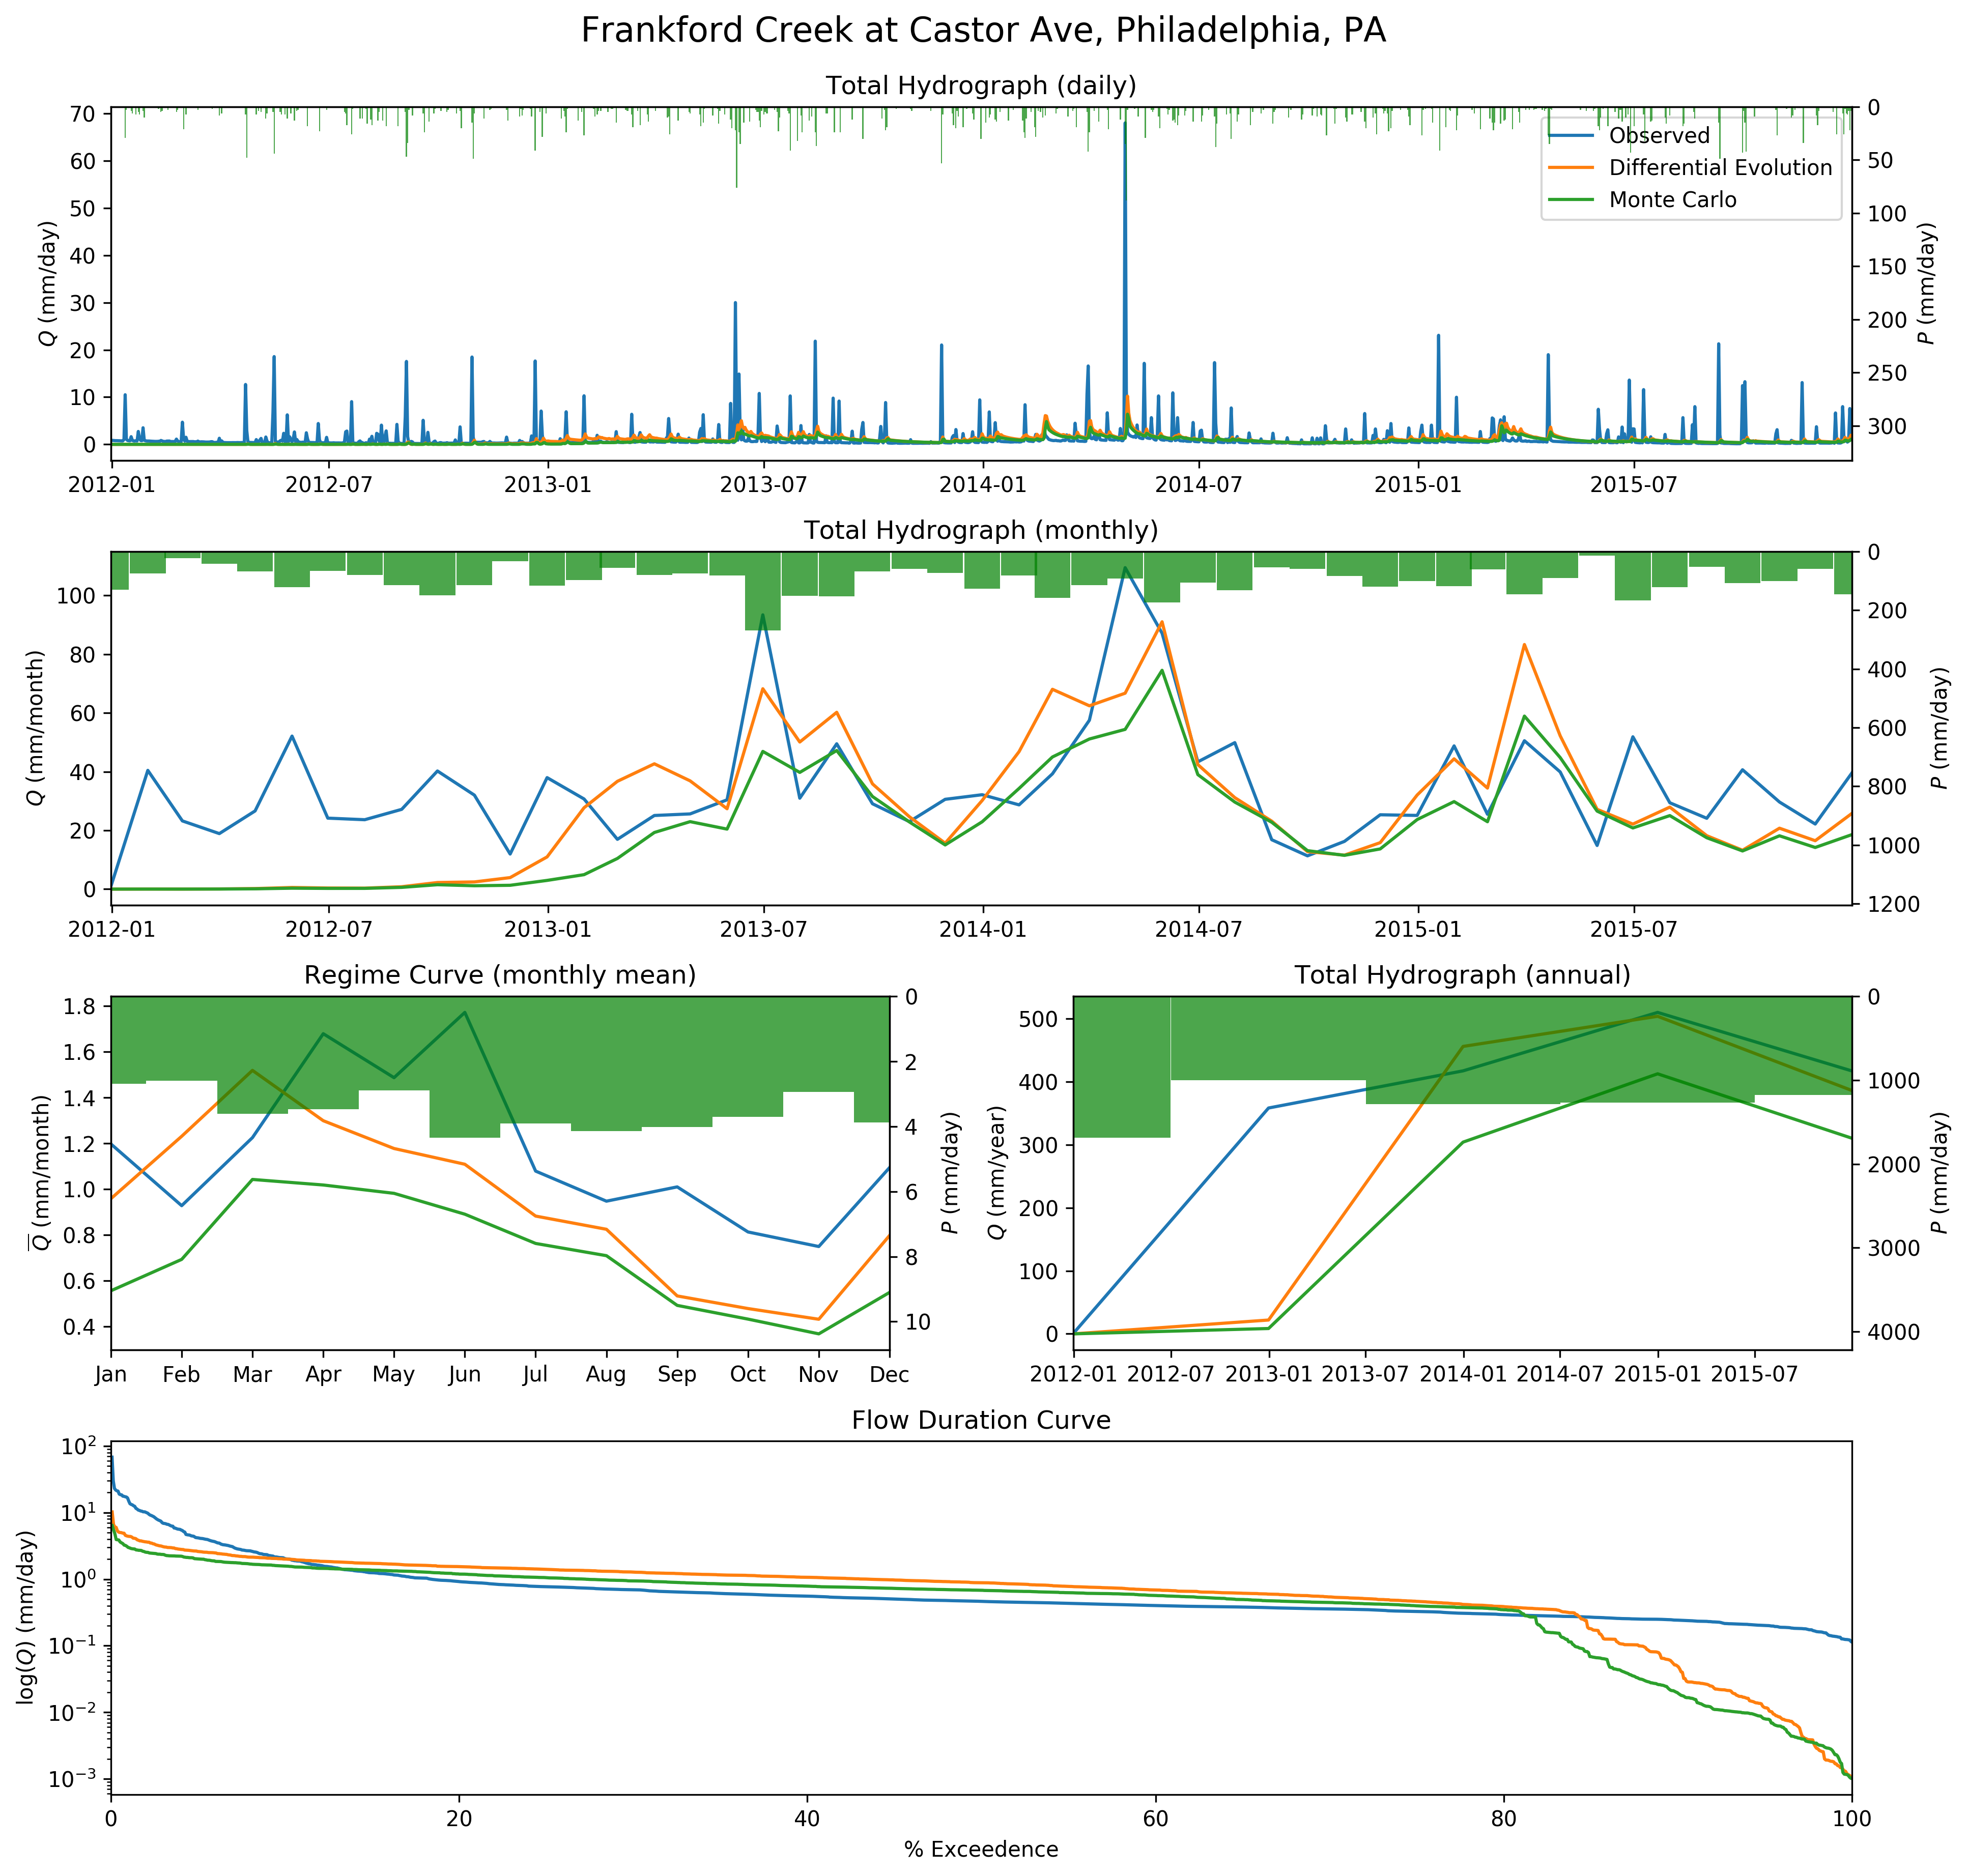

In [14]:
Q_dict = {'Observed': frankford.climate.loc[val.index, 'qobs (cms)'],
          'Differential Evolution': pd.Series(Q_diff, index=val.index),
          'Monte Carlo': pd.Series(Q_mc, index=val.index)}
frankford.plot(Q_dict=Q_dict, output=f'Simulated_{frankford.station_id}.png')

### Observed discharge for multiple stations

The `plot_discharge` function can be used to compare hydrological signatures of multiple daily discharges timeseries of multiple stations. This plot doesn't include the precipitation data and only compares the discharges. Let's compare the Frankford and Fishing watershed. The discahrge dictionary should be provided as before.

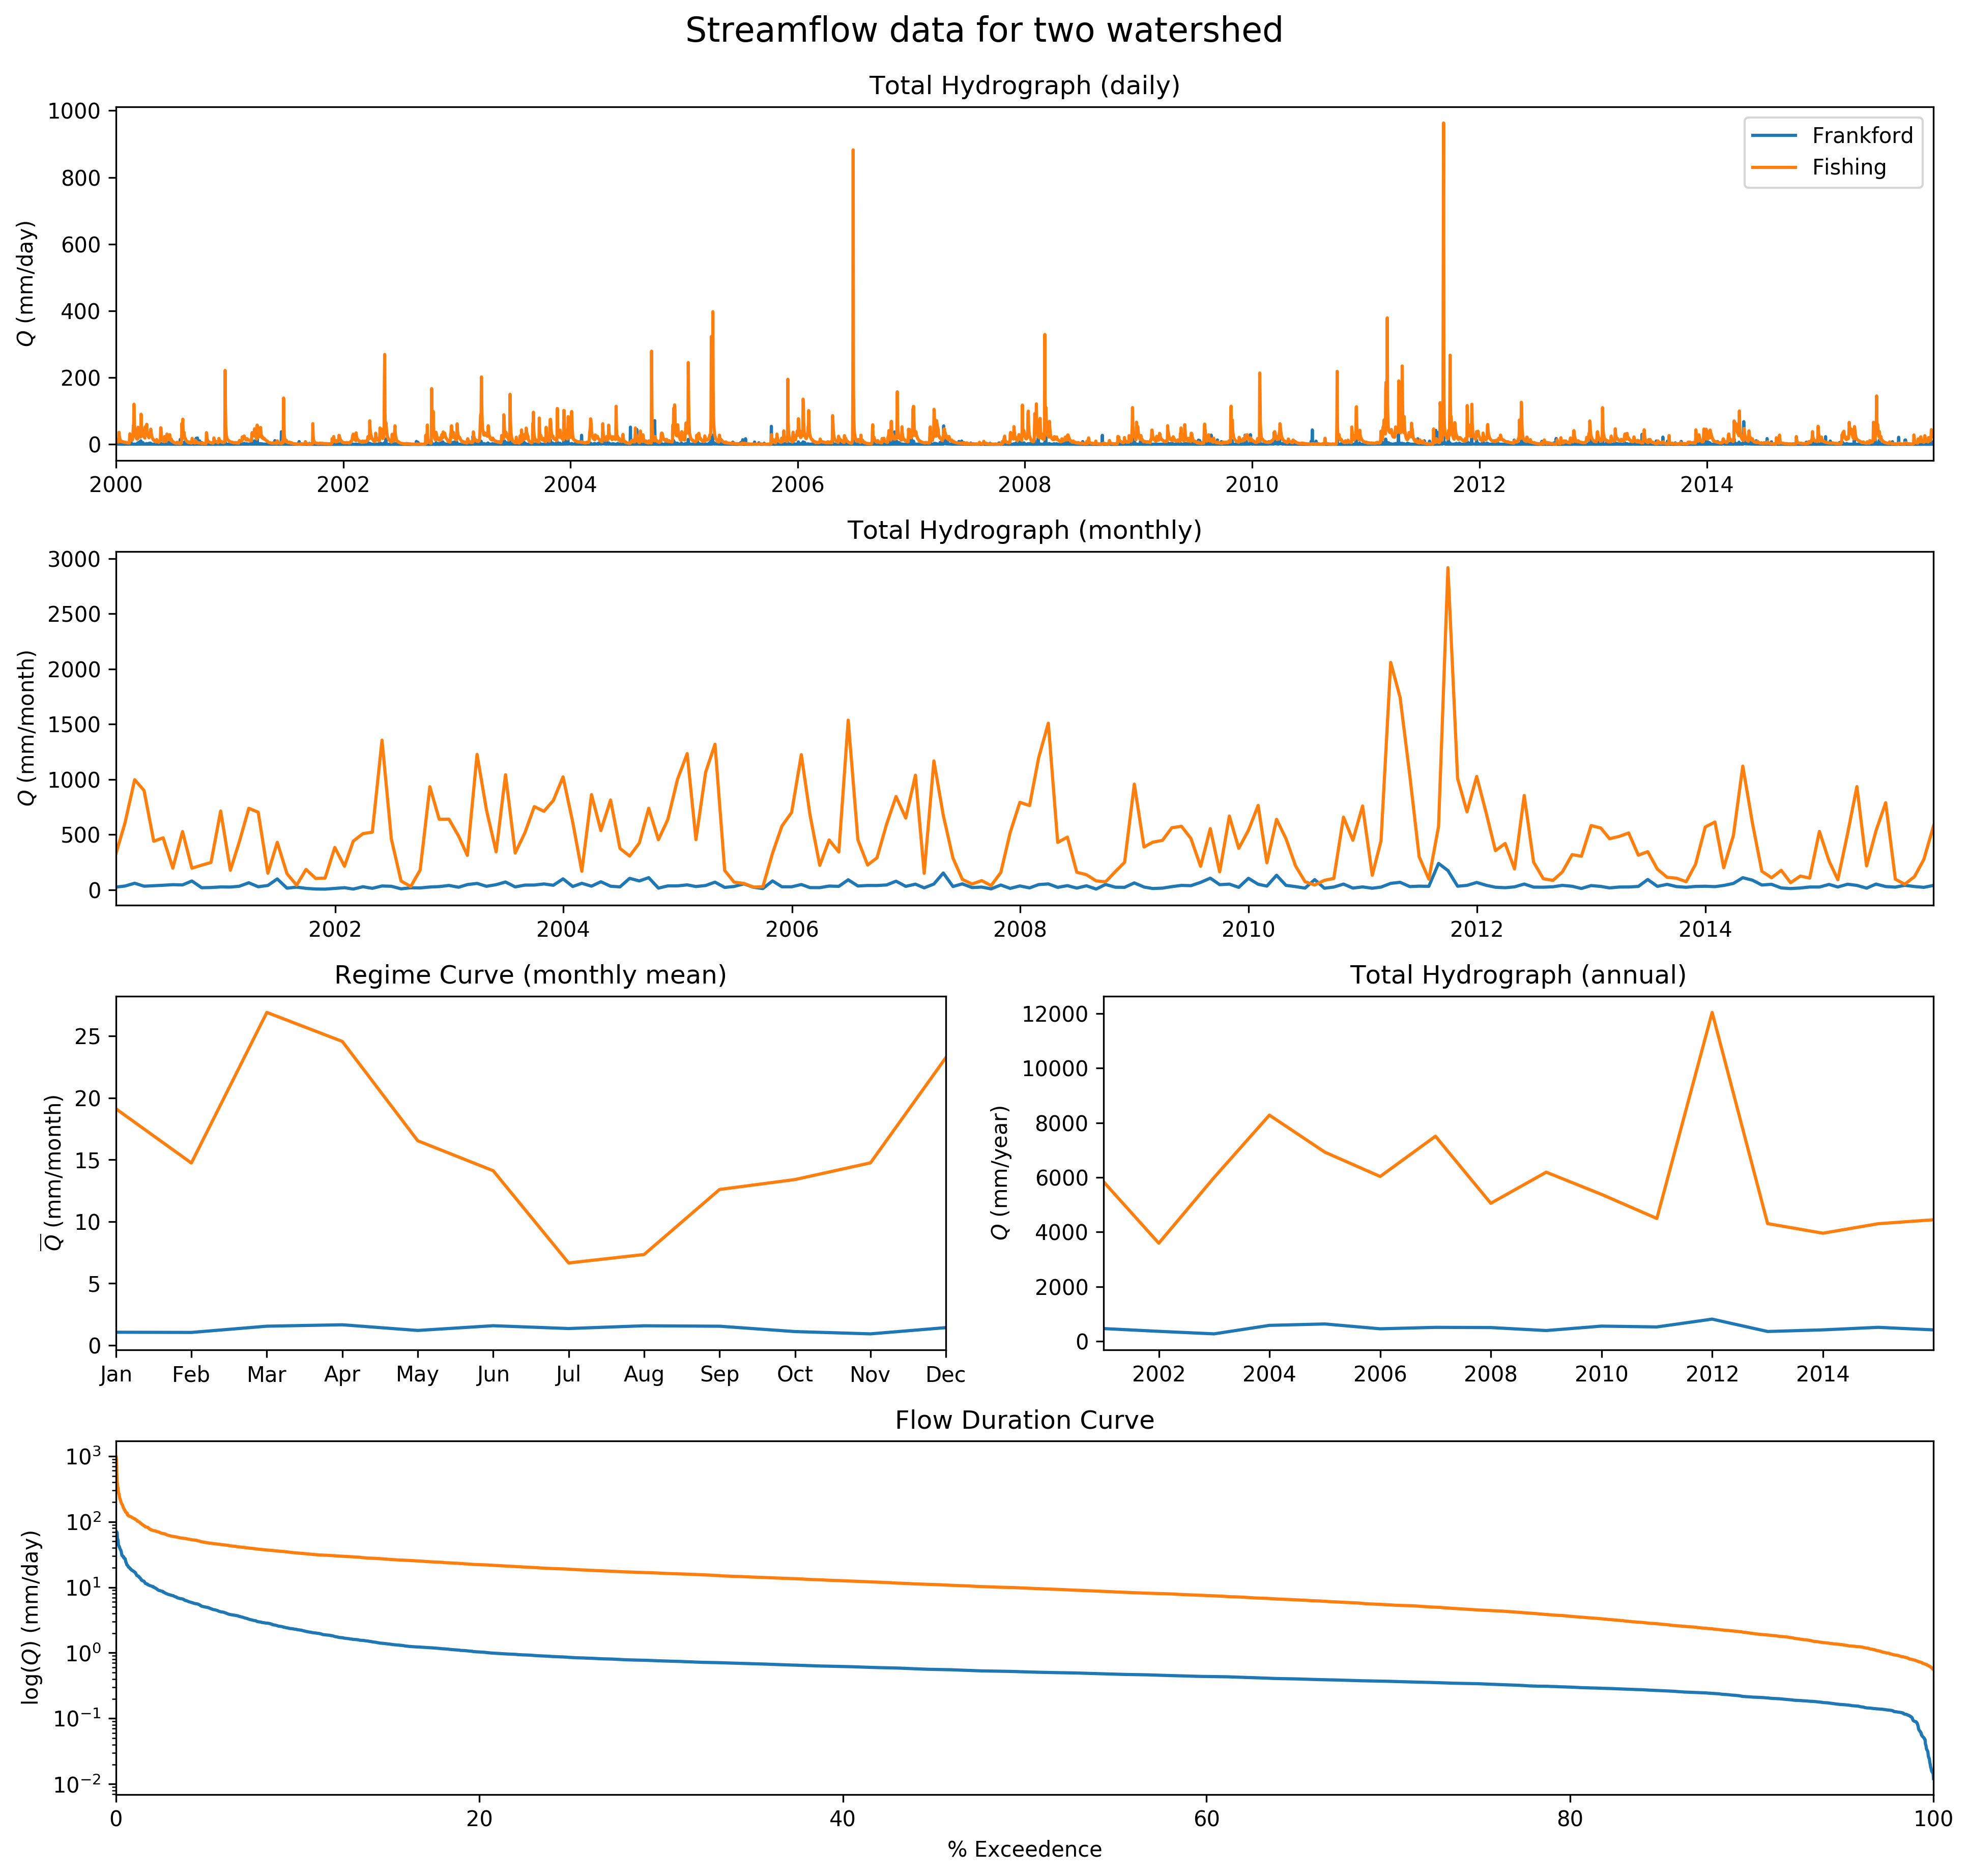

In [15]:
Q_dict = {'Frankford': frankford.climate['qobs (cms)'],
          'Fishing': fishing.climate['qobs (cms)']}
frankford.plot_discharge(Q_dict=Q_dict, title='Streamflow data for two watershed',
                         output=f'Discharges_{frankford.station_id}.png')

In [16]:
import fiona
import rasterio
import rasterio.mask

with fiona.open(frankford.gis_dir.joinpath(frankford.comid, "geometry.shp"), "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [17]:
with rasterio.open(frankford.data_dir.joinpath('canopy.geotiff')) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [18]:
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 102.0,
 'width': 2000,
 'height': 2140,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(5.734715359827902e-05, 0.0, -75.1930063800598,
        0.0, -5.7362758808143995e-05, 40.123813042523736)}

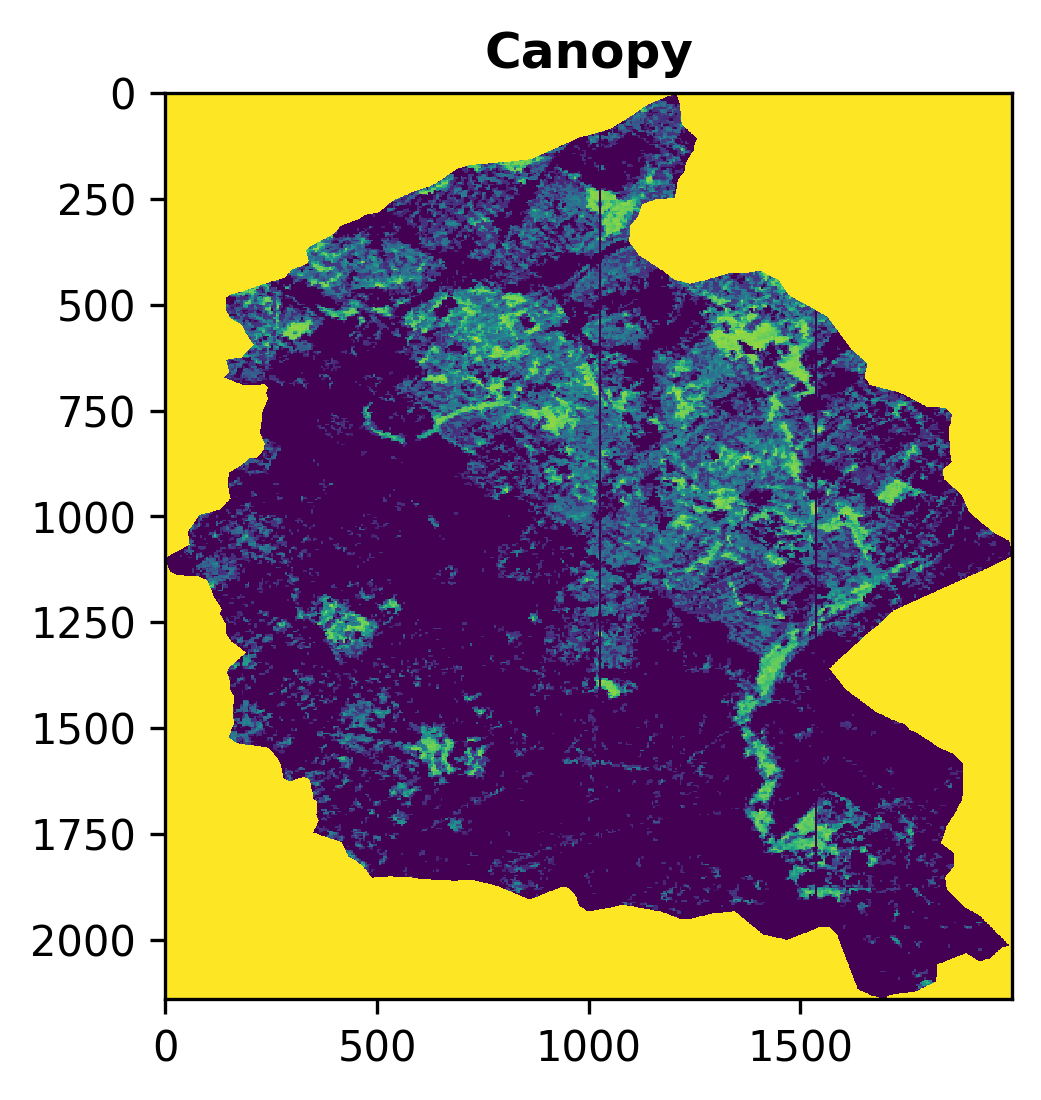

In [19]:
show(out_image, title='Canopy')